# Code

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [7]:
how = 'ricseq'

In [8]:
if how == 'splash':
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes_splash.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'splash.csv'))
elif how in ['mario', 'ricseq']:
    df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
    df = pd.read_csv(os.path.join(processed_files_dir, f'{how}.csv'))

In [4]:
drop_treshold = 10 #avoid hardneg creation problems
if how == 'ricseq':
    original_shape = df.shape[0]
    excluding_conditions = ((df.length_1 - df.w) < drop_treshold) | ((df.length_2 - df.h) < drop_treshold)
    df = df[~excluding_conditions].reset_index(drop = True)
    print('# dropped = ', original_shape - df.shape[0])

In [85]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

0 genes have N, so will be excluded


In [86]:
limit_small_rna = 7000
limit_medium_rna = 8500

print('MAX_RNA_SIZE is', MAX_RNA_SIZE)
print('limit of small rna is:', limit_small_rna)
print('limit of medium rna is:', limit_medium_rna)

small1 = df[(df.length_2<=limit_small_rna)&(df.length_1<=limit_medium_rna)] #both small and one small the other medium
small2 = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_medium_rna)] #both small and one small the other medium
df_small = pd.concat([small1, small2], axis = 0).drop_duplicates().reset_index(drop = True) #one small the other medium

df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)].reset_index(drop=True)

df_medium = df[~df.couples.isin(set(df_small.couples).union(set(df_big.couples)))].reset_index(drop=True)
assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
set(df_small.couples).union(set(df_medium.couples)).union(set(df_big.couples)) == set(df.couples)
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of contact matrixes (in the entire dataset) that are small is {perc_small}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are medium is {perc_medium}% ')
print(f'The amount of contact matrixes (in the entire dataset) that are big is {perc_big}% ')

MAX_RNA_SIZE is 5970
limit of small rna is: 7000
limit of medium rna is: 8500
The amount of contact matrixes (in the entire dataset) that are small is 98.4% 
The amount of contact matrixes (in the entire dataset) that are medium is 1.6% 
The amount of contact matrixes (in the entire dataset) that are big is 0.0% 


In [87]:
def create_sample_dict(id_couple, sample):
    """
    x1, x2, y1, y2 is where is the interaction with respect to the actual coordinates (not the original coordinates)
    length_1, length_2 is the length with respect to the actual length (not the original length)
    
    original_x1, original_x2, original_y1, original_y2 is where the rna interacts with respect to original coordinates 
    window_x1, window_x2, window_y1, window_y2 is where the rna was sampled with respect to original coordinates 
    original_length1, original_length2 is the original length
    """
    d = {
        'id_sample':id_couple,
        'couples':sample.couple_id,
        'gene1':sample.gene1,
        'gene2':sample.gene2,
        'interacting':sample.interacting,
        'length_1':sample.bbox.x2-sample.bbox.x1,
        'length_2':sample.bbox.y2-sample.bbox.y1,
        'protein_coding_1':sample.gene1_info["protein_coding"],
        'protein_coding_2':sample.gene2_info["protein_coding"],
        'x1': sample.seed_interaction_bbox.x1 - sample.bbox.x1,
        'x2': sample.seed_interaction_bbox.x2 - sample.bbox.x1,
        'y1': sample.seed_interaction_bbox.y1 - sample.bbox.y1,
        'y2': sample.seed_interaction_bbox.y2 - sample.bbox.y1,
        'policy':sample.policy,
        'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
        'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
        'original_x1':sample.seed_interaction_bbox.x1,
        'original_x2':sample.seed_interaction_bbox.x2,
        'original_y1':sample.seed_interaction_bbox.y1,
        'original_y2':sample.seed_interaction_bbox.y2,
        'window_x1':sample.bbox.x1,
        'window_x2':sample.bbox.x2,
        'window_y1':sample.bbox.y1,
        'window_y2':sample.bbox.y2,
        'original_length1':len(sample.gene1_info["cdna"]),
        'original_length2':len(sample.gene2_info["cdna"]),
        'id_gene1_sample':sample.gene1 + '_' + str(sample.bbox.x1) + '_' + str(sample.bbox.x2),
        'id_gene2_sample':sample.gene2 + '_' + str(sample.bbox.y1) + '_' + str(sample.bbox.y2)
    }
    return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    
    pol = []
    
    if ep_per_sample>0:
        pol.append(
            EasyPosAugment(
            per_sample=ep_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
            )
        )
        
    if sn_per_sample>0:
        pol.append(   
            SmartNegAugment(
                per_sample=sn_per_sample,
                interaction_selection=InteractionSelectionPolicy.LARGEST,
                width_multipliers=pos_width_multipliers,
                height_multipliers=pos_height_multipliers,
            )
        )
        
    if en_persample>0:
        pol.append( 
            EasyNegAugment(
                per_sample=en_persample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
        
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

In [88]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

In [89]:
#small policies
ep_per_sample_small=1
sn_per_sample_small=1
en_per_sample_small=1
hn_per_sample_small=1

#medium policies
ep_per_sample_medium=1
sn_per_sample_medium=1
en_per_sample_medium=1
hn_per_sample_medium=1


#big policies
ep_per_sample_big=1
sn_per_sample_big=1
en_per_sample_big=1
hn_per_sample_big=1

In [90]:
tot_ep = ep_per_sample_small*perc_small + ep_per_sample_medium*perc_medium + ep_per_sample_big*perc_big
tot_sn = sn_per_sample_small*perc_small + sn_per_sample_medium*perc_medium + sn_per_sample_big*perc_big
tot_en = en_per_sample_small*perc_small + en_per_sample_medium*perc_medium + en_per_sample_big*perc_big
tot_hn = hn_per_sample_small*perc_small + hn_per_sample_medium*perc_medium + hn_per_sample_big*perc_big

tot_neg = tot_sn + tot_en + tot_hn
print(f'expected smartneg are the {np.round( tot_sn/tot_neg *100, 2)}% of negative pairs')
print(f'expected easyneg are the {np.round( tot_en/tot_neg *100, 2)}% of negative pairs')
print(f'expected hardneg are the {np.round( tot_hn/tot_neg *100, 2)}% of negative pairs')

unbalanced_factor = df[df.interacting == False].shape[0]/df.shape[0]
expected_uf = tot_ep*unbalanced_factor / ((tot_ep*unbalanced_factor) + tot_neg)
print(f'expected unbalanced factor is {np.round(expected_uf*100, 2)}%')

expected smartneg are the 33.33% of negative pairs
expected easyneg are the 33.33% of negative pairs
expected hardneg are the 33.33% of negative pairs
expected unbalanced factor is 12.22%


# Data Loader val

In [28]:
subset_file = ''

meta = {}
id_couple = 0

In [ ]:
start_time = time.time()

small = get_dataset(ep_per_sample=ep_per_sample_small, sn_per_sample=sn_per_sample_small, 
                    en_persample=en_per_sample_small, hn_per_sample=hn_per_sample_small, 
                    df_genes=df_genes, df=df_small, subset_file=subset_file, 
                    pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                    neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small), total = len(small)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium = get_dataset(ep_per_sample=ep_per_sample_medium, sn_per_sample=sn_per_sample_medium,
                     en_persample=en_per_sample_medium, hn_per_sample=hn_per_sample_medium, 
                     df_genes=df_genes, df=df_medium, subset_file=subset_file,
                     pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                     neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium), total = len(medium)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big = get_dataset(ep_per_sample=ep_per_sample_big, sn_per_sample=sn_per_sample_big, 
                  en_persample=en_per_sample_big, hn_per_sample=hn_per_sample_big, 
                  df_genes=df_genes, df=df_big, subset_file=subset_file, 
                  pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                  neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big), total = len(big)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert (df_meta['lencdna1'] == df_meta['length_1']).all()
assert (df_meta['lencdna2'] == df_meta['length_2']).all()
assert ((df_meta.window_x2 - df_meta.window_x1)==(df_meta.lencdna1)).all()
assert ((df_meta.window_y2 - df_meta.window_y1)==(df_meta.lencdna2)).all()
df_meta = df_meta.drop(['lencdna1', 'lencdna2'], axis = 1)

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.x1 >= 0).all()
assert (m.y1 >= 0).all()
assert (m.x2 <= m.length_1).all()
assert (m.y2 <= m.length_2).all()

assert df_meta[df_meta.length_1==df_meta.original_length1][['gene1', 'id_gene1_sample']].groupby('gene1').nunique().max().iloc[0] == 1
assert df_meta[df_meta.length_2==df_meta.original_length2][['gene2', 'id_gene2_sample']].groupby('gene2').nunique().max().iloc[0] == 1

print(f"Total time to create datasets: {(time.time()-start_time)/60} minutes")

In [ ]:
df_meta.to_csv(os.path.join(metadata_dir, f'{how}.csv'), index = False)

# Create the embedding query

In [29]:
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))

In [30]:
def create_query_df(df):
    df1 = df[['id_gene1_sample', 'cdna1']].drop_duplicates().rename({'id_gene1_sample':'id_query', 'cdna1':'cdna'}, axis = 1)
    df2 = df[['id_gene2_sample', 'cdna2']].drop_duplicates().rename({'id_gene2_sample':'id_query', 'cdna2':'cdna'}, axis = 1)
    df = pd.concat([df1, df2], axis = 0).drop_duplicates().reset_index(drop = True)
    return df

In [31]:
df_query = create_query_df(df_meta).drop_duplicates().reset_index(drop = True)

In [32]:
query = set(df_meta['id_gene1_sample']).union(df_meta['id_gene2_sample'])

#the 2 assert below also means that there are unique cdna per id_query
assert len(df_query.id_query) == len(query)
assert set(df_query.id_query) == query

In [33]:
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [34]:
df_query.to_csv(os.path.join(metadata_dir, f'embedding_query.csv'), index = False)

In [97]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 5.27
estimated # days: 0.22
estimated terabytes (pessimistic): 0.23
estimated terabytes (realistic): 0.15


In [98]:
def get_directory_size(directory):
    total_size = 0
    n_files = 0
    # Walk through all the files and subdirectories in the directory
    for path, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(path, file)
            total_size += os.stat(file_path).st_size
            n_files+=1

    # Convert the size to a human-readable format
    size_in_bytes = total_size
    size_in_kilobytes = total_size / 1000
    size_in_megabytes = size_in_kilobytes / 1000
    size_in_gigabytes = size_in_megabytes / 1000
    size_in_terabytes = size_in_gigabytes / 1000

    return {
        "n_files":n_files,
        # "bytes": size_in_bytes,
        # "kilobytes": size_in_kilobytes,
        # "megabytes": size_in_megabytes,
        "gigabytes": size_in_gigabytes, 
        "terabytes": size_in_terabytes, 
    }

# Usage example
directory_path = os.path.join(embedding_dir)
print_size = False
if print_size:
    directory_size = get_directory_size(directory_path)
    print(directory_size)

# Create df_genes_nt and df_nt

In [91]:
#import data 
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))

In [92]:
def swap_if_needed(df):
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    df['need_to_swap'] = df.couples!=df.actual_couples
    where = df.need_to_swap
    df.loc[where, ['gene1', 'gene2']] = (df.loc[where, ['gene2', 'gene1']].values)
    df.loc[where, ['length_1', 'length_2']] = (df.loc[where, ['length_2', 'length_1']].values)
    df.loc[where, ['protein_coding_1', 'protein_coding_2']] = (df.loc[where, ['protein_coding_2', 'protein_coding_1']].values)
    df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
    df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
    df.loc[where, ['cdna1', 'cdna2']] = (df.loc[where, ['cdna2', 'cdna1']].values)
    df.loc[where, ['original_x1', 'original_y1']] = (df.loc[where, ['original_y1', 'original_x1']].values)
    df.loc[where, ['original_x2', 'original_y2']] = (df.loc[where, ['original_y2', 'original_x2']].values)
    df.loc[where, ['window_x1', 'window_y1']] = (df.loc[where, ['window_y1', 'window_x1']].values)
    df.loc[where, ['window_x2', 'window_y2']] = (df.loc[where, ['window_y2', 'window_x2']].values)
    df.loc[where, ['original_length1', 'original_length2']] = (df.loc[where, ['original_length2', 'original_length1']].values)
    df.loc[where, ['id_gene1_sample', 'id_gene2_sample']] = (df.loc[where, ['id_gene2_sample', 'id_gene1_sample']].values)
    if ('diff1' in df.columns)&('diff2' in df.columns):
        df.loc[where, ['diff1', 'diff2']] = (df.loc[where, ['diff2', 'diff1']].values)
    df['actual_couples'] = df.gene1 + '_' + df.gene2
    assert (df.couples==df.actual_couples).all()
    return df.drop(['need_to_swap', 'actual_couples'], axis = 1)

In [93]:
df_meta = swap_if_needed(df_meta)

In [94]:
assert len(set(df_meta.id_sample)) == len(df_meta)

In [95]:
df_meta['couples_id'] = df_meta['couples']
df_meta['couples'] = df_meta['id_sample']


print(f'{how}:', len(list(set(df_meta.couples))))

splash: 4060


#### Drop the small couples

In [96]:
min_len = 25

original_shape = df_meta.shape[0]
df_meta = df_meta[~((df_meta.length_1 < min_len) | (df_meta.length_2 < min_len))].reset_index(drop = True)
print('# dropped = ', original_shape - df_meta.shape[0])

# dropped =  0


##### Create fake_interaction_region

In [97]:
#create fake_interaction_region
interaction_size=16

def create_fake_interaction_region(df, interaction_size=16):
    subset = df[df.policy.isin(['hardneg', 'easyneg'])]
    
    length1_values = subset['length_1'].values - interaction_size
    length2_values = subset['length_2'].values - interaction_size

    # Generate random indices within the length1 range
    x1_indices = np.random.randint(0, length1_values, size=len(subset))
    x2_indices = x1_indices + interaction_size  # Ensure a distance of interaction_size between x1 and x2

    # Generate random indices within the length2 range
    y1_indices = np.random.randint(0, length2_values, size=len(subset))
    y2_indices = y1_indices + interaction_size  # Ensure a distance of interaction_size between y1 and y2
    
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x1'] = x1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'x2'] = x2_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y1'] = y1_indices
    df.loc[df.policy.isin(['hardneg', 'easyneg']), 'y2'] = y2_indices
    return df


df_meta = create_fake_interaction_region(df_meta, interaction_size=16)

assert (df_meta.x2<=df_meta.length_1).all()

assert (df_meta.x1>=0).all()


subset = df_meta[df_meta.policy.isin(['hardneg', 'easyneg'])]
assert ((subset.x2-subset.x1) == interaction_size).all()

In [98]:
df_full = df_meta
df_full = df_full.rename({'gene1':'gene1_id', 'gene2':'gene2_id'}, axis = 1)
df_full = df_full.rename({'id_gene1_sample':'gene1', 'id_gene2_sample':'gene2'}, axis = 1)

In [99]:
df_nt = df_full.copy()
df_nt['w'] = df_nt['x2'] - df_nt['x1']
df_nt['h'] = df_nt['y2'] - df_nt['y1']
column_order = ['couples','gene1','gene2','interacting',
                'length_1','length_2','protein_coding_1','protein_coding_2',
                'x1','y1','w','h', 'policy',
                'original_x1','original_x2',
                'original_y1','original_y2',
                'id_gene1_sample','id_gene2_sample', 'couples_id',
               ]
df_nt = df_nt.drop_duplicates(subset = [
    'couples','gene1','gene2','interacting',
    'length_1','length_2','protein_coding_1',
    'protein_coding_2','x1','y1','w','h',
    'policy','original_x1','original_x2',
    'original_y1','original_y2','couples_id'
]).reset_index(drop = True)
df_nt = df_nt.filter(column_order, axis = 1)
#crea coordinate per easyneg e hardneg
df_nt.to_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'), index = False)

In [100]:
column_order = [
    'gene1','gene2','id_gene1_sample','id_gene2_sample',
    'original_length1','original_length2', 'cdna1', 'cdna2',
    'window_x1','window_x2','window_y1','window_y2', 
    'gene1_id', 'gene2_id', 'protein_coding_1',  'protein_coding_2'
]

df_g = df_full.filter(column_order, axis = 1)

df_g1 = df_g.filter(
    [
    'gene1', 
    'id_gene1_sample', 
    'cdna1', 
    'window_x1',
    'window_x2', 
    'gene1_id',
    'protein_coding_1', 
    'length_1',
    'original_length1', 
    ]
).rename(
    {
    'gene1':'gene_id',
    'cdna1':'cdna', 
    'length_1':'length',
    'window_x1':'window_c1',
    'window_x2':'window_c2',
    'gene1_id':'original_gene_id', 
    'protein_coding_1':'protein_coding', 
    'original_length1':'original_length'
    }, 
    axis = 1)
df_g2 = df_g.filter(
    [
    'gene2', 
    'id_gene2_sample', 
    'cdna2', 
    'window_y1',
    'window_y2', 
    'gene2_id',
    'protein_coding_2', 
    'length_2',
    'original_length2', 
    ]
).rename(
    {
    'gene2':'gene_id',
    'cdna2':'cdna', 
    'length_2':'length',
    'window_y1':'window_c1',
    'window_y2':'window_c2',
    'gene2_id':'original_gene_id', 
    'protein_coding_2':'protein_coding', 
    'original_length2':'original_length'
    }, 
    axis = 1)

df_genes_nt = pd.concat([df_g1, df_g2], axis = 0).drop_duplicates().reset_index(drop = True)

df_genes_nt['UTR5'] = 0
df_genes_nt['CDS'] = 0
df_genes_nt['UTR3'] = 0

In [101]:
assert set(df.gene1).union(df.gene2) == set(df_meta.gene1).union(df_meta.gene2)
assert set(df.gene1).union(df.gene2) == set(df_full.gene1_id).union(df_full.gene2_id)

In [102]:
df_genes_nt.to_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'), index = False)

### Add experiment column
Ho bisogno di sapere a quale id dell esperimento corrisponde ogni riga del dataset

In [103]:
df = pd.read_csv(os.path.join(processed_files_dir, f"{how}.csv"))
df_nt = pd.read_csv(os.path.join(metadata_dir,  f'df_nt_{how}.csv'))

df['x2'] = df['x1'] + df['w']
df['y2'] = df['y1'] + df['h']
df = df.rename({'couples':'couples_id', 'x1':'original_x1', 'x2':'original_x2', 'y1':'original_y1', 'y2':'original_y2'}, axis = 1)

if how == 'splash':
    df = df[['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2', 'experiment', 'where_x1', 'where_y1', 'where']]

elif how in ['mario', 'ricseq']:
    df = df[['couples_id', 'original_x1', 'original_x2', 
             'original_y1', 'original_y2', 'name', 'other_id', 
             'experiment', 'simple_repeats', 'sine_alu', 'low_complex', 
             'n_reads', 'is_merged', 'where_x1', 'where_y1', 'where']]
df_nt_new = df_nt.merge(df, on = ['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2'])
df_nt_new = df_nt_new.drop_duplicates(['couples'])

todo = df_nt[df_nt.couples.isin(set(df_nt.couples) - set(df_nt_new.couples))]
todogenes = todo.couples_id.str.extractall('(.*)_(.*)').reset_index()
assert ( todogenes[0] == todogenes[1] ).all()

todo.couples.all
#they are negative but they are the same rnarna thats why they didnt metch

todo = todo.rename({
    'original_x1':'original_y1', 
    'original_x2':'original_y2', 
    'original_y1':'original_x1', 
    'original_y2':'original_x2', 
}, axis = 1)

last = todo.merge(df, on = ['couples_id', 'original_x1', 'original_x2', 'original_y1', 'original_y2'])
last = last.drop_duplicates(['couples'])
df_nt_new = pd.concat([df_nt_new, last], axis = 0).reset_index(drop = True)

assert set(df_nt_new.couples) == set(df_nt.couples)
assert df_nt_new.shape[0] == df_nt.shape[0] 

df_nt_new.to_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'), index = False)

# Check the data saved

In [104]:
df_meta = pd.read_csv(os.path.join(metadata_dir, f'{how}.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f"{how}.csv"))

assert max(df_meta.length_1.max(), df_meta.length_2.max()) == MAX_RNA_SIZE

In [105]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

In [106]:
# all the excluded couples belonw are few (should be zero)
not_in_df = set(df.couples) - set(df_nt.couples_id) 
print(len(df[df.couples.isin(not_in_df)]))
assert len(df[df.couples.isin(not_in_df)]) < 20

0


In [107]:
assert (df_nt.x1 >= 0).all()
assert (df_nt.y1 >= 0).all()
assert ((df_nt.x1 + df_nt.w) <= df_nt.length_1).all()
assert ((df_nt.y1 + df_nt.h) <= df_nt.length_2).all()
assert df_genes_nt.apply(lambda x: len(x.cdna) == (x.window_c2-x.window_c1), axis = 1).all()

In [108]:
pos_width_multipliers = {1_000_000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

In [109]:
dataset = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file='',
        augment_policies=policies,
)

In [110]:
def map_coordinates(window_c1, window_c2, actual_window_c1, actual_window_c2, actual_interaction_c1, actual_interaction_c2):
    real_c1 = actual_window_c1 + window_c1
    real_c2 = actual_window_c2 + window_c1
    real_interaction_c1 = actual_interaction_c1 + window_c1
    real_interaction_c2 = actual_interaction_c2 + window_c1
    return real_c1, real_c2, real_interaction_c1, real_interaction_c2

In [111]:
all_couples = set(df.couples)

for s in tqdm(dataset):
    interacting, actual_policy = s.interacting, s.policy

    couple_id = s.gene1_info['original_gene_id'] + '_' + s.gene2_info['original_gene_id']
    couple_id_swapped = s.gene2_info['original_gene_id'] + '_' + s.gene1_info['original_gene_id']
    
    if couple_id in all_couples:
        gene1_id, gene2_id = s.gene1, s.gene2
        gene1_info, gene2_info = s.gene1_info, s.gene2_info
        real_couple_id = couple_id
        actual_window_x1, actual_window_x2 = s.bbox.x1, s.bbox.x2
        actual_window_y1, actual_window_y2 = s.bbox.y1, s.bbox.y2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    elif couple_id_swapped in all_couples:
        gene2_id, gene1_id = s.gene1, s.gene2
        gene2_info, gene1_info = s.gene1_info, s.gene2_info
        actual_window_y1, actual_window_y2 = s.bbox.x1, s.bbox.x2
        actual_window_x1, actual_window_x2 = s.bbox.y1, s.bbox.y2
        actual_interaction_y1, actual_interaction_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2
        actual_interaction_x1, actual_interaction_x2 = s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
        real_couple_id = couple_id_swapped
    else:
        raise NotImplementedError
        
    original_gene_id1, original_gene_id2 = gene1_info['original_gene_id'], gene2_info['original_gene_id']
    cdna_slice1, cdna_slice2 = gene1_info['cdna'], gene2_info['cdna']
    window_x1, window_x2 = gene1_info['window_c1'], gene1_info['window_c2']
    window_y1, window_y2 = gene2_info['window_c1'], gene2_info['window_c2']
    protein_coding1, protein_coding2 = gene1_info['protein_coding'], gene2_info['protein_coding']
    original_length1, original_length2 = gene1_info['original_length'], gene2_info['original_length']
    
    policy_res = [
        i['policy'] for i in s.gene1_info['interactions'] if 
        (i['couples_id']==real_couple_id)&
        ( set([i['gene1'],i['gene2']])==set([s.gene1, s.gene2]) )
    ]
    
    assert (len(set(policy_res)) == 1) | (set(policy_res) == {'smartneg', 'easyneg'})
    policy = policy_res[0]
        
    assert gene1_id == gene1_info['gene_id']
    assert gene2_id == gene2_info['gene_id']
    assert window_x2-window_x1 == len(cdna_slice1)
    assert window_y2-window_y1 == len(cdna_slice2)
    
    real1 = df_genes[df_genes.gene_id == original_gene_id1].iloc[0]
    real2 = df_genes[df_genes.gene_id == original_gene_id2].iloc[0]

    assert real1['cdna'][window_x1:window_x2] == cdna_slice1
    assert real2['cdna'][window_y1:window_y2] == cdna_slice2
    assert real1.protein_coding == protein_coding1
    assert real2.protein_coding == protein_coding2
    
    real_df = df[df.couples == real_couple_id].iloc[0]
    if policy == 'easypos':
        assert real_df.interacting == interacting == True
        assert actual_policy == 'easypos'
    if policy == 'hardneg':
        assert real_df.interacting == True
        assert interacting == False
        assert actual_policy == 'smartneg'
    elif policy in ['smartneg', 'easyneg']:
        assert real_df.interacting == interacting == False
        assert actual_policy == 'smartneg'
    assert real_df.protein_coding_1 == protein_coding1
    assert real_df.protein_coding_2 == protein_coding2
        
    real_x1, real_x2, real_interaction_x1, real_interaction_x2 = map_coordinates(window_x1, window_x2, actual_window_x1, actual_window_x2, actual_interaction_x1, actual_interaction_x2)
    real_y1, real_y2, real_interaction_y1, real_interaction_y2 = map_coordinates(window_y1, window_y2, actual_window_y1, actual_window_y2, actual_interaction_y1, actual_interaction_y2)

    assert real_x1>=0
    assert real_y1>=0
    assert real_x1<=real_x2<=original_length1
    assert real_y1<=real_y2<=original_length2

    if (policy == 'easypos')|(policy == 'smartneg'):
        assert real_x1<=real_interaction_x1<=real_interaction_x2
        assert real_interaction_x1<=real_interaction_x2<=real_x2
        assert real_y1<=real_interaction_y1<=real_interaction_y2
        assert real_interaction_y1<=real_interaction_y2<=real_y2
    elif policy == 'hardneg':
        # le coordinate real_x1, real_x2 non sono piu buone perche avevo sovrascritto le regioni di interazione di hardneg e easyneg
        real_x1, real_x2 = real_df.x1, real_df.x1+real_df.w
        real_y1, real_y2 = real_df.y1, real_df.y1+real_df.h
        assert ( 
            (real_interaction_x2 < real_x1)|(real_interaction_x1 > real_x2) | 
            (real_interaction_y2 < real_y1)|(real_interaction_y1 > real_y2) 
        )

  0%|          | 0/3163 [00:00<?, ?it/s]

```
original      0, 10, 20, 23,24, 50, 70, 100
window           10                 70
actual_win           10         40
actual_int               13,14
```

### Check embeddings

In [112]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

In [113]:
vc_train = df_nt.interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_width_multipliers = {10_000_000: 1.}

pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

policies = [
    EasyPosAugment(
    per_sample=1,
    interaction_selection=InteractionSelectionPolicy.LARGEST,
    width_multipliers=pos_width_multipliers,
    height_multipliers=pos_height_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
    ),
]

dataset = RNADatasetNT(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file='',
        augment_policies=policies,
        data_dir = os.path.join(embedding_dir, '32'),
        scaling_factor = 20,
        min_n_groups = 5,
        max_n_groups = 80,
)

In [114]:
l1_neg, l2_neg, l1_pos, l2_pos = [], [], [], []

for s in tqdm(dataset):
    length1, length2 = s.bbox.x2-s.bbox.x1, s.bbox.y2-s.bbox.y1
    if s.interacting:
        l1_pos.append(length1)
        l2_pos.append(length2)
    else:
        l1_neg.append(length1)
        l2_neg.append(length2)

  0%|          | 0/1833 [00:00<?, ?it/s]

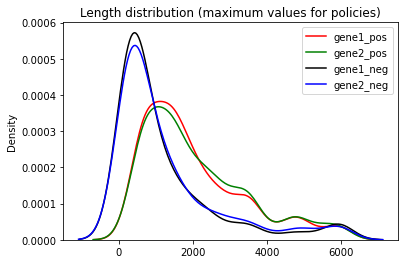

In [115]:
sns.kdeplot(l1_pos, color = 'red', label = 'gene1_pos')
sns.kdeplot(l2_pos, color = 'green', label = 'gene2_pos')
sns.kdeplot(l1_neg, color = 'black', label = 'gene1_neg')
sns.kdeplot(l2_neg, color = 'blue', label = 'gene2_neg')
plt.title(f'Length distribution (maximum values for policies)')
plt.legend()
plt.show()

# Download test set 500 nucleotides

In [116]:
import util.misc as utils
import shutil

def load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_BERT):
    source_file_path = os.path.join(dataset_files_dir, 'data.py')
    data_bert_file_path = os.path.join(dataset_files_dir, 'data_bert.py')
    shutil.copy(source_file_path, data_bert_file_path)
    new_max_rna_length = MAX_RNA_SIZE_BERT

    # Read the content of data_bert.py
    with open(data_bert_file_path, 'r') as file:
        lines = file.readlines()

    # Find and modify the MAX_RNA_LENGTH line
    modified_lines = []
    for line in lines:
        if line.startswith('MAX_RNA_SIZE'):
            modified_lines.append(f'MAX_RNA_SIZE = {new_max_rna_length}\n')
        else:
            modified_lines.append(line)

    # Write the modified content back to data_bert.py
    with open(data_bert_file_path, 'w') as file:
        file.writelines(modified_lines)

load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_BERT)

from dataset.data_bert import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    SmartNegAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    create_augment_list,
    plot_sample,
    seed_everything,
)


In [117]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

#leva quelli con regione di interazione maggiore di 500
df_nt = df_nt[~((df_nt.w>=MAX_RNA_SIZE_BERT)|(df_nt.h>=MAX_RNA_SIZE_BERT))]

pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

policies_test = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_test = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file='',
    augment_policies=policies_test,
    data_dir = os.path.join(embedding_dir, '32'),
    scaling_factor = 5,
    min_n_groups = np.nan,
    max_n_groups = 80,
)

In [118]:
test500 = []

for s in tqdm(dataset_test):
    
    gene1, gene2 = s.gene1, s.gene2

    x1, x2, y1, y2 = s.bbox.x1, s.bbox.x2, s.bbox.y1, s.bbox.y2

    seed_x1, seed_x2, seed_y1, seed_y2 = s.seed_interaction_bbox.x1, s.seed_interaction_bbox.x2, s.seed_interaction_bbox.y1, s.seed_interaction_bbox.y2
    
    interacting = s.interacting

    cdna1, cdna2 = s.gene1_info['cdna'], s.gene2_info['cdna']

    cdna1slice, cdna2slice = cdna1[x1:x2], cdna2[y1:y2]

    test500.append({
        'gene1':gene1,
        'gene2':gene2,
        'x1':x1,
        'x2':x2,
        'y1':y1,
        'y2':y2,
        'seed_x1':seed_x1,
        'seed_x2':seed_x2,
        'seed_y1':seed_y1,
        'seed_y2':seed_y2,
        'cdna1':cdna1slice,
        'cdna2':cdna2slice,
        'len1':len(cdna1slice),
        'len2':len(cdna2slice),
    })
test500 = pd.DataFrame(test500)

assert test500.len1.max() == test500.len2.max() == 500
n_rows = test500.shape[0]

  0%|          | 0/3163 [00:00<?, ?it/s]

In [119]:
test500_1 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2'], right_on = ['gene1', 'gene2'])
test500_2 = test500.merge(df_nt[['gene1', 'gene2', 'couples']], left_on = ['gene1', 'gene2'], right_on = ['gene2', 'gene1'])


test500_2 = test500_2.drop(['gene1_x', 'gene2_x'], axis = 1).rename({'gene1_y':'gene1', 'gene2_y':'gene2'}, axis = 1)
where = test500_2.len1>0 #all rows
test500_2.loc[where, ['x1', 'y1']] = (test500_2.loc[where, ['y1', 'x1']].values)
test500_2.loc[where, ['x2', 'y2']] = (test500_2.loc[where, ['y2', 'x2']].values)
test500_2.loc[where, ['seed_x1', 'seed_y1']] = (test500_2.loc[where, ['seed_y1', 'seed_x1']].values)
test500_2.loc[where, ['seed_x2', 'seed_y2']] = (test500_2.loc[where, ['seed_y2', 'seed_x2']].values)
test500_2.loc[where, ['len1', 'len2']] = (test500_2.loc[where, ['len2', 'len1']].values)
test500_2.loc[where, ['cdna1', 'cdna2']] = (test500_2.loc[where, ['cdna2', 'cdna1']].values)

#shuffling
test500 = pd.concat([test500_1, test500_2], axis = 0).sample(frac=1).reset_index(drop = True)

In [120]:
assert df_nt[df_nt.duplicated(set(df_nt.columns) - {'couples'})].shape[0] < df_nt.shape[0]*0.01

print('NB There are ', abs(n_rows - test500.shape[0]), ' duplicated in df_nt (i think they are easyneg and smartneg overlapping)')
# with respect to this key 
# df_nt['key'] = df_nt['gene1'] + '_' + df_nt['gene2'] 
# but they are few
# df_nt[(df_nt['gene1'] + '_' + df_nt['gene2']).duplicated()]

NB There are  913  duplicated in df_nt (i think they are easyneg and smartneg overlapping)


In [121]:
test500.to_csv(os.path.join(metadata_dir, f'{how}500.csv'), index = False)

### Repeats

In [122]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))

if how == 'splash':
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats_splash.csv'))
elif how in ['mario', 'ricseq']:
    df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

In [123]:
def get_features1(row):
    gene_id = row['g1']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] <= row['x2']) & (df_repeats['end'] >= row['x1']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

def get_features2(row):
    gene_id = row['g2']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] <= row['y2']) & (df_repeats['end'] >= row['y1']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

test500['g1'] = test500['gene1'].str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
test500['g2'] = test500['gene2'].str.extractall('(.*)_(.*)_(.*)').reset_index()[0]

# Apply the function to create the 'feature1' column in the test500 dataframe
test500['feature1'] = test500.apply(get_features1, axis=1) # test500['feature1']
test500['feature2'] = test500.apply(get_features2, axis=1) # test500['feature1']

In [124]:
def get_full_overlap_features1(row):
    gene_id = row['g1']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] >= row['x1']) & (df_repeats['end'] <= row['x2']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

def get_full_overlap_features2(row):
    gene_id = row['g2']
    overlaps = df_repeats[(df_repeats['gene_id'] == gene_id) & ((df_repeats['start'] >= row['y2']) & (df_repeats['end'] <= row['y1']))]
    if len(overlaps) > 0:
        return ', '.join(overlaps['feature'])
    elif gene_id in df_repeats['gene_id'].values:
        return 'None'
    else:
        return 'Not present'

In [125]:
test500['full_feature1'] = test500.apply(get_full_overlap_features1, axis=1) # test500['feature1']
test500['full_feature2'] = test500.apply(get_full_overlap_features2, axis=1) # test500['feature1']

In [126]:
test500.to_csv(os.path.join(metadata_dir, f'{how}500.csv'), index = False)

In [127]:
df_nt.policy.value_counts()

easypos     1086
hardneg     1086
smartneg     944
easyneg      944
Name: policy, dtype: int64

### Add the distance to the colosest region of interaction 

In [4]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_{how}.csv'))

test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))

In [6]:
def min_distance(interval1, interval2):
    # Sorting intervals to make sure interval1[0] is less than interval2[0]
    interval1, interval2 = sorted([interval1, interval2], key=lambda x: x[0])

    # Case where intervals overlap
    if interval1[1] >= interval2[0]:
        return 0

    # Minimum distance between non-overlapping intervals
    return interval2[0] - interval1[1]

In [7]:
gene1_coord = test500['gene1'].str.extractall('(.*)_(.*)_(.*)').reset_index()
gene2_coord = test500['gene2'].str.extractall('(.*)_(.*)_(.*)').reset_index()

test500['start_window_x'] = gene1_coord[1].astype(int) + test500['x1']
test500['end_window_x'] = gene1_coord[1].astype(int) + test500['x2']

test500['start_window_y'] = gene2_coord[1].astype(int) + test500['y1']
test500['end_window_y'] = gene2_coord[1].astype(int) + test500['y2']

In [8]:
diz = {}
for _, row in tqdm(test500.iterrows(), total = test500.shape[0]):
    g1, g2 = row.g1, row.g2
    x1,x2,y1,y2 = row.start_window_x, row.end_window_x, row.start_window_y, row.end_window_y

    couple_name = g1 + '_' + g2
    assert couple_name in set(df.couples)

    all_interactions = df[df['couples'] == couple_name]

    distances_x = []
    distances_y = []
    for _, df_row in all_interactions.iterrows():
        distances_x.append(
            min_distance([x1,x2], [df_row.x1,df_row.x1+df_row.w])
        )
        distances_y.append(
            min_distance([y1,y2], [df_row.y1,df_row.y1+df_row.h])
        )

    distance_x = min(distances_x)
    distance_y = min(distances_y)
    
    diz[row.couples] = {'distance_x':distance_x, 'distance_y':distance_y}

  0%|          | 0/4076 [00:00<?, ?it/s]

In [9]:
distances = pd.DataFrame.from_dict(diz, orient = 'index').reset_index().rename({'index':'couples'},axis =1)
test500 = test500.merge(distances, on = 'couples')
test500 = test500.merge(df_nt[['couples', 'policy']], on = 'couples')

easypos
0.0
0.0


smartneg
4482.0
4112.0


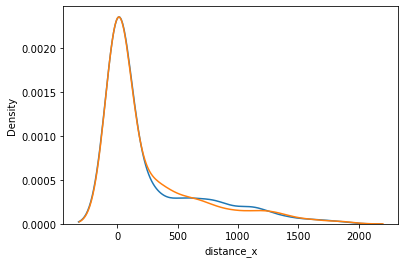



easyneg
6272.0
5318.0


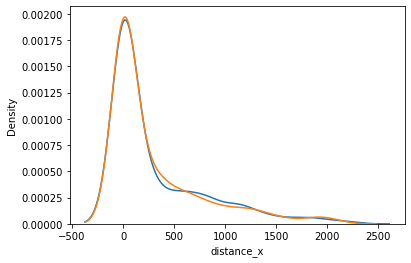



hardneg
7097.0
5717.0


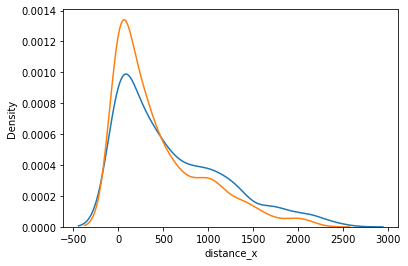

In [10]:
def filter_percentile_for_plot(data, percentile = 0.95):
    # Calculate the 95th percentile value
    percentile_95 = data.quantile(percentile)

    # Filter values less than the 95th percentile
    filtered_values = data[data < percentile_95]
    
    return filtered_values

for p in ['easypos', 'smartneg', 'easyneg', 'hardneg']:
    print(p)
    print(test500[test500.policy == p].distance_x.max())
    print(test500[test500.policy == p].distance_y.max())
    
    if test500[test500.policy == p].distance_x.max() >0:
        sns.kdeplot(filter_percentile_for_plot(test500[test500.policy == p].distance_x))
        sns.kdeplot(filter_percentile_for_plot(test500[test500.policy == p].distance_y))
        plt.show()

    print('\n')